In [2]:
from pyspark.sql.functions import col, expr, row_number

In [3]:
# setup - create spark session
from pyspark.sql import SparkSession
spark = (SparkSession.builder.appName("cs544")
         .master("spark://main:7077")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", "hdfs://main:9000/user/hive/warehouse")
         .enableHiveSupport()
         .getOrCreate())

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/03/31 21:22:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# setup - download datasets
!wget https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
!wget https://pages.cs.wisc.edu/~harter/cs639/data/code_sheets.zip

--2023-03-29 23:00:59--  https://pages.cs.wisc.edu/~harter/cs639/data/hdma-wi-2021.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21494278 (20M) [application/zip]
Saving to: ‘hdma-wi-2021.zip.1’

hdma-wi-2021.zip.1  100%[===================>]  20.50M  28.6MB/s    in 0.7s    

2023-03-29 23:01:00 (28.6 MB/s) - ‘hdma-wi-2021.zip.1’ saved [21494278/21494278]

--2023-03-29 23:01:00--  https://pages.cs.wisc.edu/~harter/cs639/data/arid2017_to_lei_xref_csv.zip
Resolving pages.cs.wisc.edu (pages.cs.wisc.edu)... 128.105.7.9
Connecting to pages.cs.wisc.edu (pages.cs.wisc.edu)|128.105.7.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 144804 (141K) [application/zip]
Saving to: ‘arid2017_to_lei_xref_csv.zip.1’

arid2017_to_lei_xre 100%[===================>] 141.41K  --.-KB/s    in 0.1s    

2023-03-29 23:01:01 (1.22

In [4]:
# setup - extract datasets
!unzip hdma-wi-2021.zip
!unzip arid2017_to_lei_xref_csv.zip
!unzip code_sheets.zip

Archive:  hdma-wi-2021.zip
replace hdma-wi-2021.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  arid2017_to_lei_xref_csv.zip
replace arid2017_to_lei_xref_csv.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
Archive:  code_sheets.zip
replace action_taken.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [5]:
# setup - save in hdfs and spark
import os
directory = os.fsencode("/notebooks");
code_sheets_list = ["ethnicity.csv", "race.csv", "sex.csv", "states.csv", "counties.csv", "tracts.csv", "action_taken.csv", "denial_reason.csv", "loan_type.csv", "loan_purpose.csv", "preapproval.csv", "property_type.csv"]

#store in hdfs and create views
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".csv"):
        !hdfs dfs -cp {filename} hdfs://main:9000/{filename}
        if filename in code_sheets_list:
            (spark.read.format("csv")
                .option("header", True)
                .option("inferSchema", True)
                .load(f"hdfs://main:9000/{filename}")).createOrReplaceTempView(filename.split(".")[0])
#banks
(spark.read.format("csv")
    .option("header", True)
    .option("inferSchema", True)
    .load("hdfs://main:9000/arid2017_to_lei_xref_csv.csv")).write.saveAsTable("banks", mode="overwrite")

#loans
spark.read.csv(f"hdfs://main:9000/hdma-wi-2021.csv", header=True, inferSchema=True).write.bucketBy(8, "county_code").saveAsTable("loans", mode="overwrite")
        

23/03/31 21:25:09 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/banks was not found. Was it deleted very recently?
23/03/31 21:25:10 WARN FileUtils: File does not exist: hdfs://main:9000/user/hive/warehouse/banks; Force to delete it.
23/03/31 21:25:10 ERROR FileUtils: Failed to delete hdfs://main:9000/user/hive/warehouse/banks
23/03/31 21:25:14 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.
23/03/31 21:25:14 WARN HiveConf: HiveConf of name hive.internal.ss.authz.settings.applied.marker does not exist
23/03/31 21:25:14 WARN HiveConf: HiveConf of name hive.stats.jdbc.timeout does not exist
23/03/31 21:25:14 WARN HiveConf: HiveConf of name hive.stats.retries.wait does not exist
23/03/31 21:25:23 WARN HadoopFSUtils: The directory hdfs://main:9000/user/hive/warehouse/loans was not found. Was it deleted very recently?
23/03/31 21:25:24 WARN FileUtils: File does not exist

In [6]:
#Q1
spark.sql("SHOW TABLES").show()

+---------+-------------+-----------+
|namespace|    tableName|isTemporary|
+---------+-------------+-----------+
|  default|        banks|      false|
|  default|        loans|      false|
|         | action_taken|       true|
|         |     counties|       true|
|         |denial_reason|       true|
|         |    ethnicity|       true|
|         | loan_purpose|       true|
|         |    loan_type|       true|
|         |  preapproval|       true|
|         |property_type|       true|
|         |         race|       true|
|         |          sex|       true|
|         |       states|       true|
|         |       tracts|       true|
+---------+-------------+-----------+



In [5]:
#Q2

# banks with first
print(spark.sql("""
SELECT *
FROM banks
WHERE LOWER(respondent_name) LIKE '%first%'
""").count())

# banks with second
spark.sql("""
SELECT *
FROM banks
WHERE LOWER(respondent_name) LIKE '%second%'
""").toPandas()


525


,respondent_name,arid_2017,lei_2018,lei_2019,lei_2020
0,Old Second National Bank,14596,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08,B94HV8SXGDD3J5XESU08


In [6]:
#Q3
# I choose Badger Bank
q3_results = spark.sql("""
SELECT *
FROM banks
INNER JOIN loans 
ON banks.lei_2020 = loans.lei
WHERE respondent_name = 'Badger Bank'
""")
q3_results.count()


242

In [7]:
#Q4

#1. The banks table is sent to every executor via a BroadcastExchange operation.
#2. The banks table has "is not null" filtering added by the optimizer.
#3. No, the plan does not involve HashAggregates.

q3_results.explain("formatted")

== Physical Plan ==
AdaptiveSparkPlan (7)
+- BroadcastHashJoin Inner BuildLeft (6)
   :- BroadcastExchange (3)
   :  +- Filter (2)
   :     +- Scan parquet default.banks (1)
   +- Filter (5)
      +- Scan parquet default.loans (4)


(1) Scan parquet default.banks
Output [5]: [respondent_name#947, arid_2017#948, lei_2018#949, lei_2019#950, lei_2020#951]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/banks]
PushedFilters: [IsNotNull(respondent_name), EqualTo(respondent_name,Badger Bank), IsNotNull(lei_2020)]
ReadSchema: struct<respondent_name:string,arid_2017:string,lei_2018:string,lei_2019:string,lei_2020:string>

(2) Filter
Input [5]: [respondent_name#947, arid_2017#948, lei_2018#949, lei_2019#950, lei_2020#951]
Condition : ((isnotnull(respondent_name#947) AND (respondent_name#947 = Badger Bank)) AND isnotnull(lei_2020#951))

(3) BroadcastExchange
Input [5]: [respondent_name#947, arid_2017#948, lei_2018#949, lei_2019#950, lei_2020#951]
Arguments: Hashed

In [7]:
#Q5

#create column with county in loans
spark.sql("""
SELECT *, CAST(SUBSTRING(county_code,3,3) AS int) AS county, SUBSTRING(county_code,1,2) AS state, loan_purpose AS loan_purpose_id, action_taken AS action_taken_id
FROM loans
""").createOrReplaceTempView('p5_loans')

# distinct counties
spark.sql("""
SELECT DISTINCT STATE, CAST(COUNTY AS INT), NAME
FROM counties;
""").createOrReplaceTempView("distinct_counties")

#join everything
spark.sql("""
SELECT lei, banks.respondent_name, action_taken.action_taken, census_tract, loan_purpose.loan_purpose, distinct_counties.NAME,  derived_dwelling_category, loan_amount, interest_rate, loan_term
FROM p5_loans
LEFT JOIN banks ON p5_loans.lei = banks.lei_2020
LEFT JOIN loan_purpose ON p5_loans.loan_purpose_id = loan_purpose.id
LEFT JOIN action_taken ON p5_loans.action_taken_id = action_taken.id
LEFT JOIN distinct_counties ON (p5_loans.county = distinct_counties.COUNTY AND p5_loans.state = distinct_counties.state)
""").createOrReplaceTempView("p5_loans")

#Gather necessary columns
spark.sql("""
SELECT census_tract, NAME AS county, loan_purpose,derived_dwelling_category, loan_amount / 1000 AS thousands, interest_rate, loan_term / 12 AS years, action_taken
FROM p5_loans
WHERE respondent_name = 'Badger Bank'
ORDER BY thousands DESC
LIMIT 10
""").toPandas()


,census_tract,county,loan_purpose,derived_dwelling_category,thousands,interest_rate,years,action_taken
0,55055100100,Jefferson,None,Multifamily:Site-Built,2095.0,3.9,5.0,Loan originated
1,55055100700,Jefferson,Home purchase,Single Family (1-4 Units):Site-Built,995.0,4.0,5.0,Loan originated
2,55055101300,Jefferson,Home purchase,Multifamily:Site-Built,745.0,3.75,5.0,Loan originated
3,55055101300,Jefferson,Home purchase,Multifamily:Site-Built,725.0,3.75,5.0,Loan originated
4,55055101500,Jefferson,Home purchase,Multifamily:Site-Built,605.0,3.75,5.0,Loan originated
5,55055100601,Jefferson,Home purchase,Single Family (1-4 Units):Site-Built,545.0,3.125,30.0,Loan originated
6,55133200901,Waukesha,None,Single Family (1-4 Units):Site-Built,545.0,2.875,30.0,Loan originated
7,55055100602,Jefferson,None,Single Family (1-4 Units):Site-Built,545.0,2.625,20.0,Loan originated
8,55055100700,Jefferson,Home purchase,Single Family (1-4 Units):Site-Built,535.0,2.875,30.0,Loan originated
9,55085970900,Oneida,Home purchase,Single Family (1-4 Units):Site-Built,525.0,3.125,30.0,Loan originated


In [74]:
#Q6

spark.sql("""
SELECT county_code, AVG(loan_amount) AS average_loan
FROM LOANS
GROUP BY county_code 
""").explain("formatted")

spark.sql("""
SELECT lei, AVG(loan_amount) AS average_loan
FROM LOANS
GROUP BY lei
""").explain("formatted")

# From both the physical plans spark gives us, we can see that a network i/o is required only
# when grouping by lei as seen with the exchange operation. This is because of the way we loaded
# our data into a hive table. By using bucketBy,
# it partitioned our data in a Spark Dataset into a fixed number of buckets based on county_code.
# each bucket is stored as a separate file on disk, and Spark can keep track of the bucketing metadata.
# This will lower the network i/o as it minimizes data shuffling across the network. 

== Physical Plan ==
AdaptiveSparkPlan (4)
+- HashAggregate (3)
   +- HashAggregate (2)
      +- Scan parquet default.loans (1)


(1) Scan parquet default.loans
Output [2]: [county_code#976, loan_amount#993]
Batched: true
Location: InMemoryFileIndex [hdfs://main:9000/user/hive/warehouse/loans]
ReadSchema: struct<county_code:string,loan_amount:double>
SelectedBucketsCount: 8 out of 8

(2) HashAggregate
Input [2]: [county_code#976, loan_amount#993]
Keys [1]: [county_code#976]
Functions [1]: [partial_avg(loan_amount#993)]
Aggregate Attributes [2]: [sum#5749, count#5750L]
Results [3]: [county_code#976, sum#5751, count#5752L]

(3) HashAggregate
Input [3]: [county_code#976, sum#5751, count#5752L]
Keys [1]: [county_code#976]
Functions [1]: [avg(loan_amount#993)]
Aggregate Attributes [1]: [avg(loan_amount#993)#5746]
Results [2]: [county_code#976, avg(loan_amount#993)#5746 AS average_loan#5745]

(4) AdaptiveSparkPlan
Output [2]: [county_code#976, average_loan#5745]
Arguments: isFinalPlan=false



Text(0, 0.5, 'Average Interest Rate')

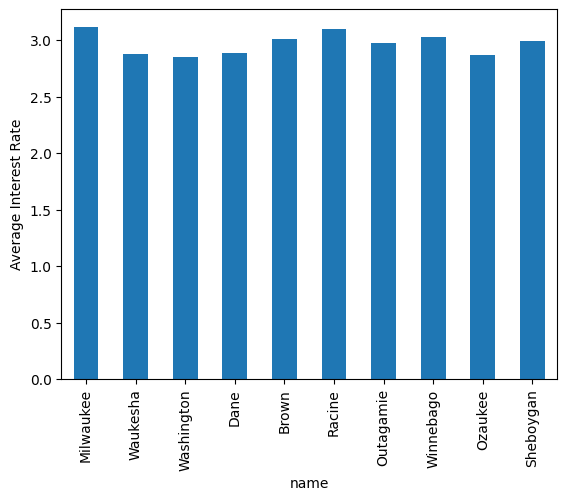

In [103]:
#Q7
wells_fargo = spark.sql("""
SELECT respondent_name, NAME, COUNT(*) as count, AVG(interest_rate) AS avg_intr
FROM p5_loans
GROUP BY respondent_name, NAME
HAVING respondent_name = "Wells Fargo Bank, National Association"
ORDER BY count DESC
LIMIT 10
""").toPandas()

ax = wells_fargo.plot.bar(x='NAME', y='avg_intr', rot=90, legend=False)
ax.set_xlabel("name")
ax.set_ylabel("Average Interest Rate")

Text(0, 0.5, '2nd Biggest Loan Application (Millions $)')

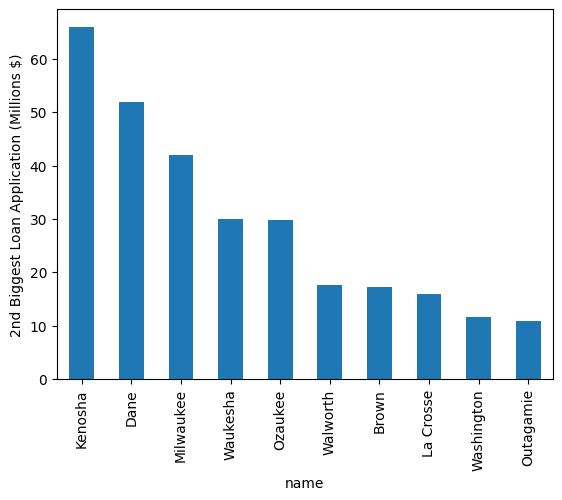

In [127]:
#Q8
second_max_counties = spark.sql("""
SELECT DISTINCT NAME, nth_value(loan_amount/1000000, 2) over (partition by NAME order by loan_amount/1000000 desc) AS second_max
FROM p5_loans
WHERE NAME != 'None'
ORDER BY second_max DESC
LIMIT 10
""").toPandas()

ax = second_max_counties.plot.bar(x='NAME', y='second_max', rot=90, legend=False)
ax.set_xlabel("name")
ax.set_ylabel("2nd Biggest Loan Application (Millions $)")

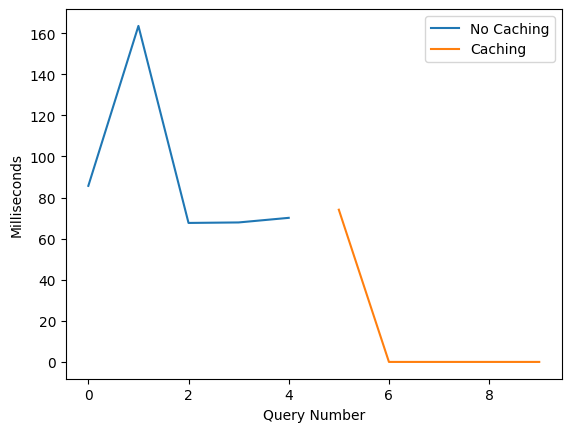

In [45]:
#Q9
import time
import matplotlib.pyplot as plt

time_list_no_cache = []
time_list_cache = []
cache = {}

wells_fargo_loans = spark.sql("""
SELECT interest_rate
FROM banks
INNER JOIN loans
ON banks.lei_2020 = loans.lei 
WHERE banks.respondent_name = 'Wells Fargo Bank, National Association'
""")

for i in range(10):
    if i < 5:
        #Perform no caching
        start = time.time()
        wells_fargo_loans.count();
        end = time.time()
        time_list_no_cache.append((end - start) * 100);
    else:
        #Perform caching
        start = time.time()
        if wells_fargo_loans in cache:
            end = time.time();
            time_list_cache.append((end - start) * 100)
        else:
            cache[wells_fargo_loans] = wells_fargo_loans.count()
            end = time.time();
            time_list_cache.append((end - start) * 100)
plt.plot(list(range(5)),time_list_no_cache, label = "No Caching")
plt.plot(list(range(5,10)),time_list_cache, label = "Caching")
plt.xlabel('Query Number')
plt.ylabel('Milliseconds')
plt.legend(loc="upper right")

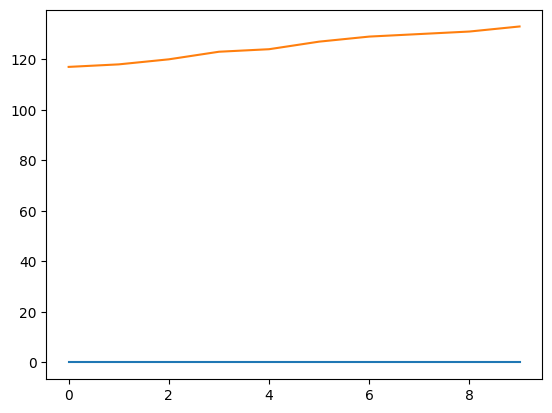

In [71]:
#Q10
import requests

wells_fargo_loans = wells_fargo_loans.repartition(1)
first_worker_tasks = []
second_worker_tasks = []
cache = {}
app_id = requests.get("http://localhost:4040/api/v1/applications").json()[0]['id']
# requests.get("http://localhost:4040/api/v1/applications/"+app_id+"/executors").json()

for i in range(10):
    cache[wells_fargo_loans] = wells_fargo_loans.count()
    info = requests.get("http://localhost:4040/api/v1/applications/"+app_id+"/executors").json()
    first_worker_tasks.append(info[0]['completedTasks'])
    second_worker_tasks.append(info[1]['completedTasks'])

plt.plot(list(range(10)),first_worker_tasks)
plt.plot(list(range(10)),second_worker_tasks)